 Created by Zachary Switzer &nbsp;&nbsp;|&nbsp;&nbsp; Spring 2019 &nbsp;&nbsp;|&nbsp;&nbsp; The George Washington University - MAE 6226

## <P style = "text-align: center;"> Performance of Monoplanes, Biplanes, and Triplanes

### <P style = "text-align: center;"> A Comparison to <i> "Model Airplane Design and Theory of Flight" </i>by Charles Grant [1]

<img src="Fokker_DR1.JPG" height="300" width="700">

### What are Monoplanes, Biplanes, and Triplanes?
Most people have seen or at least have a general undertsanding of what biplanes (an aircraft with two fixed-wings, in which one is stacked above the other) look like, and nowadays almost everyone has ridden in a monoplane (an aircraft with a single fixed-wing) [2],[3]. However, planes with more wings have historically been used much less and as a result are generally less widely known. Triplanes are also fixed wing aircraft, in which wings are stacked above one another, but have three wings instead of two [4]. 

### When were biplanes and triplanes used and why don't we see them as much nowadays?
Biplanes and triplanes were mainly used in WWI due to the fact that the technology for cantilever wings, which is used in monoplanes, had not been fully developed [5]. The box girder bracing structure of biplanes and triplanes evenly distributed loads throughout the aircraft, allowed for greater stability, and allowed for light materials to be used in the wings of planes [6]. With the developments in engine power and wing structural design in the period after WWI, monoplanes gained popularity as they overcame the speed limit inherent in biplanes and triplanes due to the excess drag created by their support struts [5],[7].

Biplanes and triplanes aren’t utilized as much nowadays mainly because of the speed and lift limitations that are present due to their design. The struts that connect wings and act as structural support also disrupt the flow around the wings and create excess drag that limits speed of the aircraft. Distance between wings also affects the flow around airfoils and can significantly decrease the overall lift of the aircraft if wings are placed too close to one another. However, this decrease in overall lift also allows biplanes and triplanes to fly at larger angles of attack and lower speeds before stalling compared to monoplanes [5]. 

### The Goal:
This project is motivated by and follows the incredibly insightful book <i> "Model Airplane Design and Theory of Flight" </i>  by Charles Grant, in which Grant compares the performance of monoplanes, biplanes, and triplanes. In this tutorial we will compare the results (mainly in terms of lift, streamlines, and Cp) gained from a Python-implemented Panel Method and an XFLR5 model to the results described by Charles Grant [1]. By the end of this tutorial you will not only have a much greater understanding of the theory behind monoplanes, biplanes, and triplanes but also (hopefully!) a greater appreciation for the incredible technological advances that have gone into the planes that we fly in today and often take for granted.

<img src="Red_Baron_Albatros.JPG" height="300" width="700">

We begin this tutorial as we do with every great AeroHydro tutorial: by importing our libraries and loading our airfoil geometry! 

Because biplanes and triplanes dominated WWI, for this tutorial we will use the Gottingen 174 airfoil from the Albatros D.II, which was used by Manfred von Richthofen (the Red Baron) in November 1916 when he shot down his famous adversary British ace Major Lanoe Hawker VC [8]. This airfoil was acquired from airfoiltools.com and can be found under the name "GOE-174 (Albatros 5020)". 

In [1]:
# importing libraries
import numpy
import os
from scipy import integrate, linalg
import math
from helper import *
import pandas
from matplotlib import pyplot
%matplotlib inline

In [2]:
# load the geometry of the GOE-174 airfoil
GOE_174 = os.path.join('data', 'GOE-174.csv')
with open(GOE_174, 'r') as infile:
    x_m, y_m = numpy.loadtxt(infile, dtype=float, unpack=True, delimiter=',')
    
# determine the number of points in the geometry
N = len(x_m)
#print(N)

And just like that we've already created the airfoil that we'll use to simulate the monplane wing.

The first thing that we'll need to do to venture out of the realm of monoplanes is to add multiple airfoils to the flow and manipulate their position in the space that we're testing in. To do this, let's create a simple function to translate the airfoil geometry from its primary location (the origin) to another location of our choosing. 

This function works off the simple principle that if we want to move a point (or group of points that make up an airfoil in this case) we need to add an offset value to each point's x and y coordinates. 

$$x' =\ x + x_{new}$$
$$y' =\ y + y_{new}$$

In [3]:
# move the geometry of the airfoils
def translate_geo(x_foil, y_foil, x_new, y_new):
    x = x_foil+x_new
    y = y_foil+y_new
    return x,y

Great! Now we can position two or three airfoils in the same flowstream and simulate a biplane or triplane.

Before we get ahead of ourselves though, we'll want to consult <i> "Model Airplane Design and Theory of Flight" </i> and get an idea of what our setup should be.

<img src="gap_length.JPG">

From p.32 Grant states that, “The gap between two airfoils affects efficiency and lift; while it is convenient to place them close, the closer they are the less lift is produced as a combination, and efficiency is reduced.” He also mentions that, "If the wings are set so the gap equals three times the chord, there is practically no loss of lift or efficiency." 

Grant then adds, "It is usually inconvenient to combine wings with a gap greater than 1 ½ times the chord. Customarily the gap equals the wing chord; for by making the gap wider, struts are lengthened and enough added resistance is produced to neutralize any gain in efficiency. It is suggested that the gap equal 1 ½ times the chord when applying this principle to models. Never use a gap less than once, nor more than three times the chord, for there is no advantage in doing so."

<img src="BiPlane_Lift_Chord_vs_Gap.JPG" height="300" width="600">

Grant then presents the figure above in which the lift of biplanes at different angles of attack and with different gap to chord ratios (in % values) are compared to a monoplane's lift (assuming the same wing area), which is set at a reference value of 100%. Since we are only focused on the airfoil and not the full wing itself, we will use wings of the same chord length and assume that the wing span is also the same (since area = chord x span). 

### Step 1:
Following the information Grant has just presented, our first step will be to create biplanes with the same gap/chord ratios and angles of attack presented in the table above and see if our lift values match Grant's. We will then continue to increase the gap/chord ratio and see if the lift vlaue of the biplane actually approaches that of the monoplane as the gap/chord ratio approaches 3.

During this tutorial we will not do any efficiency evaluations, as efficiency (Lift/Drag) requires us to calculate drag, which we can't do under the invisicid flow assumption which we will be following. 

Since the chord length of our airfoil is 1 (as the airfoil's leading edge is at x=0 and its trailing edge is at x=1) we only need to focus on the gap length. Let's first create each of the four biplanes described in the gap/chord vs lift table.

In [4]:
# create the 2nd airfoil for the biplane
# move the second airfoil up by the gap length in the y direction and 0.0 in the x direction
# gap 1: 0.75
x_n1, y_n1 = 0.0, 0.75
x_bi_1, y_bi_1 = translate_geo(x_m, y_m, x_n1, y_n1)

# gap 2: 1.0
x_n2, y_n2 = 0.0, 1.0
x_bi_2, y_bi_2 = translate_geo(x_m, y_m, x_n2, y_n2)

# gap 3: 1.25
x_n3, y_n3 = 0.0, 1.25
x_bi_3, y_bi_3 = translate_geo(x_m, y_m, x_n3, y_n3)

# gap 4: 1.5
x_n4, y_n4 = 0.0, 1.5
x_bi_4, y_bi_4 = translate_geo(x_m, y_m, x_n4, y_n4)

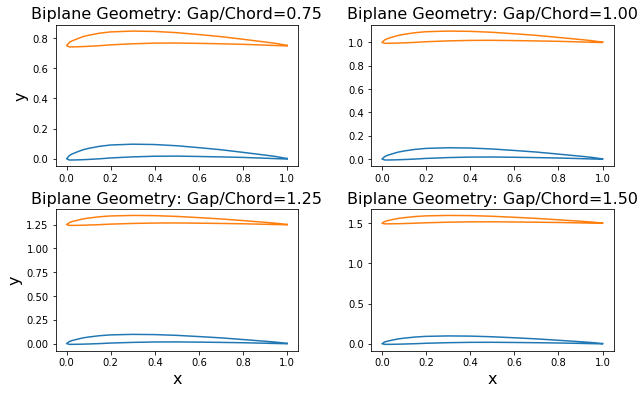

In [5]:
# plot the geometry
subplots_plot_biplane_geo(x_m, y_m,x_bi_1, y_bi_1,x_bi_2, y_bi_2,x_bi_3, y_bi_3,x_bi_4, y_bi_4)

### The Panel Method:
Now that our 1st biplane geometry has been created we'll need to incorporate the angle of attack values and eventually solve for lift in order to match Grant's table. To do this we'll use the Panel Method as described in Lesson 11. The first step in the panel method will be to discretize the airfoil geometries into panels, at the center of which we will do our calculations. The function for discretizing the panels can be found in helper.py.

In [6]:
# create the panel class
class Panel:
    def __init__(self, xa, ya, xb, yb):

        self.xa, self.ya = xa, ya  # panel starting-point
        self.xb, self.yb = xb, yb  # panel ending-point
        
        self.xc, self.yc = (xa + xb) / 2, (ya + yb) / 2  # panel center
        self.length = numpy.sqrt((xb - xa)**2 + (yb - ya)**2)  # panel length
        
        # orientation of panel (angle between x-axis and panel's normal)
        if xb - xa <= 0.0:
            self.beta = numpy.arccos((yb - ya) / self.length)
        elif xb - xa > 0.0:
            self.beta = numpy.pi + numpy.arccos(-(yb - ya) / self.length)
        
        # panel location
        if self.beta <= numpy.pi:
            self.loc = 'upper'  # upper surface
        else:
            self.loc = 'lower'  # lower surface
        
        self.sigma = 0.0  # source strength
        self.vt = 0.0  # tangential velocity
        self.cp = 0.0  # pressure coefficient

# define the panels
def define_panels(x, y, N):
    
    # becuase we were given the end-points in the geometry, we don't need to create and map the circle
    # create panels
    panels = numpy.empty(N, dtype=object)
    
    for i in range(N):
        panels[i] = Panel(x[i], y[i], x[i + 1], y[i + 1])
    
    return panels

In [7]:
# create the panels / discretize the geometry
# we use N-1 as there are N total points so there should be N-1 panels

# discretize the lower airfoil
lower_panels_bi = define_panels(x_m, y_m, N-1)

# discretize each of the upper airfoils
# gap 1: 0.75
upper_panels_bi_1 = define_panels(x_bi_1, y_bi_1, N-1)
# gap 2: 1.00
upper_panels_bi_2 = define_panels(x_bi_2, y_bi_2, N-1)
# gap 3: 1.25
upper_panels_bi_3 = define_panels(x_bi_3, y_bi_3, N-1)
# gap 4: 1.50
upper_panels_bi_4 = define_panels(x_bi_4, y_bi_4, N-1)

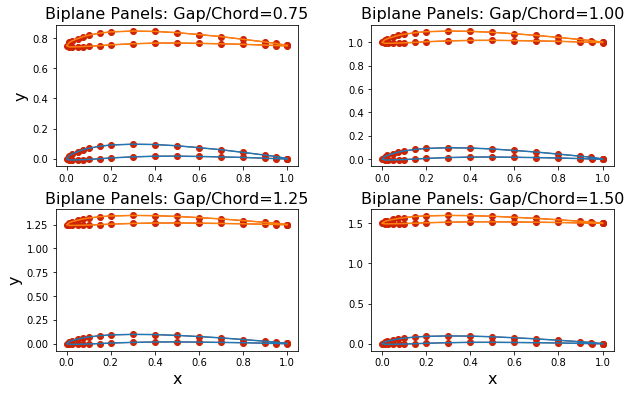

In [8]:
# modify the discretized panels for plotting
subplots_plot_biplane_panels(x_m, y_m,x_bi_1, y_bi_1,x_bi_2, y_bi_2,x_bi_3, y_bi_3,\
                             x_bi_4, y_bi_4,lower_panels_bi,upper_panels_bi_1, \
                             upper_panels_bi_2,upper_panels_bi_3, upper_panels_bi_4)

Great! Now that we've discretized our geometries into panels we can get down to incorporating the angles of attack and solving for lift.

First let's define our Freestream condition. For the freestream we need to define the flow speed $U_\infty$ and the angle of attack $\alpha=0$. Setting a different value for angle of attack will give us each of the columns in the gap/chord vs lift table described by Grant. 

In [9]:
# create the freestream
class Freestream:
    def __init__(self, u_inf=1.0, alpha=0.0):
        self.u_inf = u_inf
        self.alpha = numpy.radians(alpha)  # degrees to radians
        
# define freestream conditions
freestream_4 = Freestream(u_inf=1.0, alpha=4.0)
freestream_6 = Freestream(u_inf=1.0, alpha=6.0)
freestream_8 = Freestream(u_inf=1.0, alpha=8.0)
freestream_10 = Freestream(u_inf=1.0, alpha=10.0)

### Flow Tangency Boundary Condition

Now we will incorporate the flow tangency boundary condition. This will make the body geometry correspond to a dividing streamline, as flow is not permitted to penetrate through the panels. To do this for each panel $i$, we make $u_n=0$ at $(x_{c_i},y_{c_i})$, and we will add a source strength $\sigma$ and a vortex strength $\gamma$ to each panel. We will follow the same assumptions seen in lessons 10 and 11 for $\sigma$ and $\gamma$. This will lead to:

$$
\begin{align*}
0 &= V_\infty \cos \left(\alpha-\beta_i\right) + \frac{\sigma_i}{2} + \sum_{j=1,j\neq i}^N \frac{\sigma_j}{2\pi} \int_j \frac{\partial}{\partial n_i} \ln \left(\sqrt{(x_{c_i}-x_j(s_j))^2+(y_{c_i}-y_j(s_j))^2} \right) {\rm d}s_j - \sum_{j=1,j\neq i}^N \frac{\gamma}{2\pi} \int_j \frac{\partial}{\partial n_i} \tan^{-1} \left(\frac{y_{c_i}-y_j(s_j)}{x_{c_i}-x_j(s_j)}\right) {\rm d}s_j
\end{align*}
$$

Let's run the functions for the integral, and the source and vortex contributions. They can be seen with other functions in helper.py. To make things easier for us let's also combine the two discretized geometries of the upper and lower wing into one list that we can use to find the source and vortex contributions from. Then let's use this to find the source and vortex contibutions.

From now on though, let's just worry about working with the biplane with a gap/chord ratio = 0.75. We'll incorporate the others later.

In [10]:
# combine the discretized geometries
# gap 1: 0.75
panelS_bi_1=numpy.concatenate((lower_panels_bi, upper_panels_bi_1))
# gap 2: 1.00
panelS_bi_2=numpy.concatenate((lower_panels_bi, upper_panels_bi_2))
# gap 3: 1.25
panelS_bi_3=numpy.concatenate((lower_panels_bi, upper_panels_bi_3))
# gap 4: 1.50
panelS_bi_4=numpy.concatenate((lower_panels_bi, upper_panels_bi_4))

# 1st biplane
# gap 1: 0.75
A_source_bi_1 = source_contribution_normal(panelS_bi_1)
B_vortex_bi_1 = vortex_contribution_normal(panelS_bi_1)

### Solve the Linear System
Because each airfoil has N-1 panels, there will be $(N-1)+(N-1)+2$ unknowns, with $(N-1)+(N-1)$ unknowns corresponding to the source strengths, and 2 unknowns corresponding to the two vortex strengths.

The following equations can then be found for the center of each $i^{th}$ panel:

$$
u_{n_i} \left( {x_c}_i, {y_c}_i \right) = b^n_i + \sum_{j = 1}^{2(N-1)} A^n_{ij} \sigma_j + \sum_{j = 1}^{(N-2)} B^n_{ij} \gamma_a + \sum_{j = (N-1)}^{2(N-1)} B^n_{ij} \gamma_b
$$
$$
u_{t_i} \left( {x_c}_i, {y_c}_i \right) = b^t_i + \sum_{j = 1}^{2(N-1)} B^n_{ij} \sigma_j - \sum_{j = 1}^{(N-2)} A^n_{ij} \gamma_a - \sum_{j = (N-1)}^{2(N-1)} A^n_{ij} \gamma_b
$$

with:

$$
A^n_{ij} = \frac{1}{2 \pi} \int_0^{l_j} \frac{\left( {x_c}_i - \xi_j(s) \right) \cos\beta_i + \left( {y_c}_i - \eta_j(s) \right) \sin\beta_i}{\left( {x_c}_i - \xi_j(s) \right)^2 + \left( {y_c}_i - \eta_j(s) \right)^2} ds
$$

$$
B^n_{ij} = \frac{1}{2 \pi} \int_0^{l_j} \frac{\left( {y_c}_i - \eta_j(s) \right) \cos\beta_i - \left( {x_c}_i - \xi_j(s) \right) \sin\beta_i}{\left( {x_c}_i - \xi_j(s) \right)^2 + \left( {y_c}_i - \eta_j(s) \right)^2} ds
$$

Since there are $(N-1)+(N-1)+2$ unknowns we will need two Kutta Conditions to solve for each vortex strength that is needed to keep the stagnation point attached to the trailing edge of each airfoil. 

$$
u_{t_1} + u_{t_{(N-2)}} = 0
$$

$$
u_{t_{(N-1)}} + u_{t_{2(N-1)}} = 0
$$

In order to solve for the different source strengths at each panel and the vortex strength values for each airfoil we'll need to build a linear system. This system will incorporate the source and vortex contributions as well as the freestream contributions. The linear system should take the form: 

$$[A][\sigma,\gamma] = [b]$$

All of the functions that we will use to do this can be found in helper.py. Let's run the rest of the functions that we'll need to solve for the linear system. Now let's solve the linear system for the 1st biplane!

In [11]:
# For AOA = 4 degrees build the singularity matrix
# gap 1: 0.75
A_bi_1 = build_singularity_matrix(A_source_bi_1, B_vortex_bi_1, N)
b_bi4_1 = build_freestream_rhs(panelS_bi_1, freestream_4, N)

# solve for the singularity matrices
strengths_bi4_1 = numpy.linalg.solve(A_bi_1,b_bi4_1)

#store the strengths on each panel
for i, panel in enumerate(panelS_bi_1):
    panel.sigma = strengths_bi4_1[i]

# store the circulation density
gamma_bi4_1 = strengths_bi4_1[-2:]
print(gamma_bi4_1)

[0.2042057  0.17558401]


Now let's create functions to compute the tangential velocity and surface pressure coefficient. The pressure coefficient for each panel will be: $$C_{p_i} = 1 - \left(\frac{V_{t_i}}{U_\infty}\right)^2$$
This can be found in helper.py as well.

In [12]:
# compute the tangential velocity
compute_tangential_velocity(panelS_bi_1, freestream_4, gamma_bi4_1, A_source_bi_1, B_vortex_bi_1, N)
        
# compute the pressure coefficient
compute_pressure_coefficient(panelS_bi_1, freestream_4)

Now let's check the accuracy. We should see that the sum of all of the sources approaches 0 closed body.

In [13]:
# check that the work so far is correct => for a closed body the sum of the strengths must = 0
accuracy_bi4_1 = sum([panel.sigma*panel.length for panel in panelS_bi_1])
print('sum of singularity strengths: {:0.6f}'.format(accuracy_bi4_1))

sum of singularity strengths: -0.011056


Looks good! Now let's solve for the lift. Here lift will be $L = - \int_{\text{main}} p \mathbf{n} \cdot \mathbf{j} dl - \int_{\text{flap}} p \mathbf{n} \cdot \mathbf{j} dl$, where $\mathbf{j}$ is the unit vector in the direction of the lift force. Pressure can be found from bernoulli's equation: $P = 0.5 P_\infty \rho (U_{\infty}^2 - U_{ti}^2) $.

In [14]:
# assume that P_inf = 0, density = 1 => use bernouli's equation
P_inf=0
den=1
u_inf=1.0

# tangential velocity of the panels
foil_vt = [panel.vt for panel in panelS_bi_1[:-(N-1)]]
flap_vt = [panel.vt for panel in panelS_bi_1[-(N-1):]]

# length of the panels
foil_len = [panel.length for panel in panelS_bi_1[:-(N-1)]]
flap_len = [panel.length for panel in panelS_bi_1[-(N-1):]]

# angle of the panels called n*j (beta)
foil_angle = [panel.beta for panel in panelS_bi_1[:-(N-1)]]
flap_angle = [panel.beta for panel in panelS_bi_1[-(N-1):]]

# foil lift array
loquat = numpy.empty(N-1, dtype=float)
for i in range (N-1):
    loquat[i]=-(P_inf+0.5*den*(u_inf**2-foil_vt[i]**2))*foil_len[i]*math.sin(foil_angle[i])
    
# flap lift array
mango = numpy.empty(N-1, dtype=float)
for i in range (N-1):
    mango[i]=-(P_inf+0.5*den*(u_inf**2-flap_vt[i]**2))*flap_len[i]*math.sin(flap_angle[i])

# summing the lift arrays and ading them up
L_bi4_1=numpy.sum(loquat)+numpy.sum(mango)
print ('This is the value of the lift for the system: '+'\n'+str(L_bi4_1))

This is the value of the lift for the system: 
0.7025208209664381


Great! But this value for lift doesn't really mean much without referencing to the other values that we still need to solve for. With that being said let's solve for the rest of the values in the gap/chord vs lift table. But before we get ahead of ourselves let's create a function to do all of these steps so that we don't have to write all of it out everytime.

In [15]:
L_test = solve_biplane(panelS_bi_1, freestream_4, N)
print('This is the value of the lift for the system: '+'\n'+str(L_test))

This is the value of the lift for the system: 
0.7025208209664381


That should make things easier! Let's go ahead and run all our values through it to get the lifts for all of the biplane models at each angle of attack.

In [16]:
# Freestream = 4 deg
# gap 1: 0.75
L_bi4_1 = solve_biplane(panelS_bi_1, freestream_4, N)
# gap 2: 1.00
L_bi4_2 = solve_biplane(panelS_bi_2, freestream_4, N)
# gap 3: 1.25
L_bi4_3 = solve_biplane(panelS_bi_3, freestream_4, N)
# gap 4: 1.50
L_bi4_4 = solve_biplane(panelS_bi_4, freestream_4, N)

# Freestream = 6 deg
# gap 1: 0.75
L_bi6_1 = solve_biplane(panelS_bi_1, freestream_6, N)
# gap 2: 1.00
L_bi6_2 = solve_biplane(panelS_bi_2, freestream_6, N)
# gap 3: 1.25
L_bi6_3 = solve_biplane(panelS_bi_3, freestream_6, N)
# gap 4: 1.50
L_bi6_4 = solve_biplane(panelS_bi_4, freestream_6, N)

# Freestream = 8 deg
# gap 1: 0.75
L_bi8_1 = solve_biplane(panelS_bi_1, freestream_8, N)
# gap 2: 1.00
L_bi8_2 = solve_biplane(panelS_bi_2, freestream_8, N)
# gap 3: 1.25
L_bi8_3 = solve_biplane(panelS_bi_3, freestream_8, N)
# gap 4: 1.50
L_bi8_4 = solve_biplane(panelS_bi_4, freestream_8, N)

# Freestream = 10 deg
# gap 1: 0.75
L_bi10_1 = solve_biplane(panelS_bi_1, freestream_10, N)
# gap 2: 1.00
L_bi10_2 = solve_biplane(panelS_bi_2, freestream_10, N)
# gap 3: 1.25
L_bi10_3 = solve_biplane(panelS_bi_3, freestream_10, N)
# gap 4: 1.50
L_bi10_4 = solve_biplane(panelS_bi_4, freestream_10, N)

Now we need to find the lift for the monplane at all 4 angles of attack so that we can convert all of the lift values from the biplanes to percentages. To do this we'll use the same type of functions that we used for the biplane, but in this case we will only need one Kutta condition (as there is only one airfoil). The functions we'll be using will come from lesson 11, and can be found once again in helper.py.

In [17]:
#  find the lift of the monoplane at different angles of attack
# here we need to multiply by 2 in order to make sure that 
# the monoplane and biplane have the same area
# freestream = 4 deg
L_m4 = 2*solve_monoplane(lower_panels_bi, freestream_4,N)
# freestream = 6 deg
L_m6 = 2*solve_monoplane(lower_panels_bi, freestream_6,N)
# freestream = 8 deg
L_m8 = 2*solve_monoplane(lower_panels_bi, freestream_8,N)
# freestream = 10 deg
L_m10 = 2*solve_monoplane(lower_panels_bi, freestream_10,N)
print(L_m4, L_m6, L_m8, L_m10)

0.9065698170139187 1.1831894909778125 1.4557999792838814 1.723073151035803


Now that we have all of our data, we can put it in table format and compare it to the gap/chord vs lift table Grant provides.

In [18]:
data = numpy.round(numpy.array([[L_bi4_1/L_m4, L_bi6_1/L_m6, L_bi8_1/L_m8, L_bi10_1/L_m10],
                   [L_bi4_2/L_m4, L_bi6_2/L_m6, L_bi8_2/L_m8, L_bi10_2/L_m10],
                   [L_bi4_3/L_m4, L_bi6_3/L_m6, L_bi8_3/L_m8, L_bi10_3/L_m10],
                   [L_bi4_4/L_m4, L_bi6_4/L_m6, L_bi8_4/L_m8, L_bi10_4/L_m10]])*100, decimals = 1)
row_header = ['0.75','1.00','1.25','1.50']
column_header = ([['AOA','','',''],['4 deg','6 deg','8 deg','10 deg']])
df = pandas.DataFrame(data, row_header, column_header)
df.index.name = 'Gap/Chord'
df

AOA                   
          4 deg 6 deg 8 deg 10 deg
Gap/Chord                         
0.75       77.5  77.7  77.8   77.9
1.00       83.7  83.7  83.7   83.7
1.25       87.9  87.8  87.8   87.8
1.50       90.8  90.7  90.6   90.6

Great! We can see that at each angle of attack columns seem to be within roughly 2% of the values that Grant provides. However, we also see that the rows for each angle of attack are reletively constant, which we don't see in Grant's table. This makes sense from the panel method side of things as the lift of the biplane and the monoplane should increase somewhat linearly by and by a similar rate for if the only variable we change is angle of attack and if we stay within a small angle of attack range. The discrepencies with Grant's table could be due to a number of reasons, as Grant doesn't go into much explanation on how he gets the results in the table. These results could be experimental results, they could include the struts, which we have not included in our model and which would change the aerodynamics, and they could be based on different assumptions than the ones we're using.

Now let's keep increasing the gap/chord ratio for one of the angles of attack (I like the number 6, so let's choose 6 degrees) and see when the lift of the biplane approaches that of the monoplane. Let's create a function that does it all (in helper.py of course)!

In [19]:
# increase the biplane gap length
y_start = y_n4+0.25
y_end = 3.75
y_n = numpy.arange(y_start, y_end, 0.25)

# gap 5 (1.75) - gap 11 (3.25)
L_bi6_5 = everything_biplane(x_m, y_m, x_n1, y_n[0],lower_panels_bi, freestream_6)
L_bi6_6 = everything_biplane(x_m, y_m, x_n1, y_n[1],lower_panels_bi, freestream_6)
L_bi6_7 = everything_biplane(x_m, y_m, x_n1, y_n[2],lower_panels_bi, freestream_6)
L_bi6_8 = everything_biplane(x_m, y_m, x_n1, y_n[3],lower_panels_bi, freestream_6)
L_bi6_9 = everything_biplane(x_m, y_m, x_n1, y_n[4],lower_panels_bi, freestream_6)
L_bi6_10 = everything_biplane(x_m, y_m, x_n1, y_n[5],lower_panels_bi, freestream_6)
L_bi6_11 = everything_biplane(x_m, y_m, x_n1, y_n[6],lower_panels_bi, freestream_6)
L_bi6_12 = everything_biplane(x_m, y_m, x_n1, y_n[7],lower_panels_bi, freestream_6)

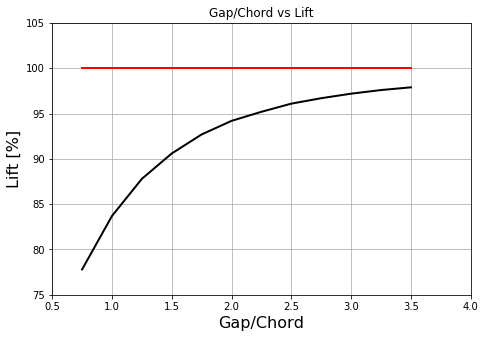

In [20]:
Lift_percent = ((numpy.round(numpy.array([L_bi6_5/L_m6, L_bi6_6/L_m6, \
                                                 L_bi6_7/L_m6, L_bi6_8/L_m6, L_bi6_9/L_m6, \
                                                 L_bi6_10/L_m6,L_bi6_11/L_m6, L_bi6_12/L_m6])*100, decimals = 1)))

Lift_mono = numpy.ones((12,1))*100
Lift_percent_tot = [data[0,2], data[1,2], data[2,2], data[3,2],Lift_percent[0],\
                    Lift_percent[1], Lift_percent[2], Lift_percent[3], Lift_percent[4],\
                    Lift_percent[5], Lift_percent[6], Lift_percent[7]]
gap = numpy.arange(0.75, 3.75, 0.25)

gap_chord_6(gap, Lift_percent_tot,Lift_mono)

In [21]:
Lift_percent.shape = (1,8)
column_header = ([['Gap/Chord','','','','','','','' ],\
                  ['1.75','2.00','2.25', '2.50', '2.75', '3.00', '3.25', '3.5']])
row_header = (['AOA = 6 degrees'])
df = pandas.DataFrame(Lift_percent, row_header ,column_header)
#df.index.name = 'Gap/Chord'
df

Gap/Chord                                          
                     1.75  2.00  2.25  2.50  2.75  3.00  3.25   3.5
AOA = 6 degrees      92.7  94.2  95.2  96.1  96.7  97.2  97.6  97.9

From the plot and the table of gap/chord we can see that as the gap/chord ratio appraoches 3, the biplane's lift does approach that of the monplane's and the loss in lift becomes quite small, as Grant described. However, we also see that even after a gap/chord ratio of 3, the lift of the biplane is still not able to reach that of the monoplane. This is likely due to the minor aerodynamic influences that the two airfoils have on one another, and we would likely see the biplanes lift approach that of the monoplane as the gap/chord ratio approached infinity.

### Step 2:

Now that we've shown a similar result to the table presented by Grant on p.32 let's look back to <i> "Model Airplane Design and Theory of Flight" </i> for some more direction. We can see that on p.34 Grant presents a similar table in which he compares the lift of monoplanes, biplanes, and triplanes at angles of attack ranging from 0-12 degrees for a gap/chord ratio of 1.25. Here, Grant chooses a gap/chord ratio of 1.25 as he states, "The customary gap, as in a biplane is 1 or 1 ½ times the wing chord. A gap of not less than ¾ nor more than 1 ½ times the chord is advisable. Of course the larger the gap the more efficient the wings are, resulting in greater lift, but with the reservations above.”

<img src="Monoplane_vs_Biplane_vs_Triplane.JPG" height="200" width="500">

Let's now create a triplane and a biplane with a gap/chord ratio of 1.25 to match the table Grant presents. In order to use the panel method on for a triplane we will not only have to change the geometry so that we incorportate and discretize 3 airfoils, but we will also have to change our linear system and incorporate 3 Kutta conditions as follows:

$$
u_{n_i} \left( {x_c}_i, {y_c}_i \right) = b^n_i + \sum_{j = 1}^{3(N-1)} A^n_{ij} \sigma_j + \sum_{j = 1}^{(N-1)/3} B^n_{ij} \gamma_a + \sum_{j = 1+(N-1)/3}^{2(N-1)/3} B^n_{ij} \gamma_b + \sum_{j = 1+2(N-1)/3}^{(N-1)} B^n_{ij} \gamma_c
$$

$$
u_{t_i} \left( {x_c}_i, {y_c}_i \right) = b^t_i + \sum_{j = 1}^{3(N-1)} B^n_{ij} \sigma_j - \sum_{j = 1}^{(N-1)/3} A^n_{ij} \gamma_a - \sum_{j = 1+(N-1)/3}^{2(N-1)/3} A^n_{ij} \gamma_b - \sum_{j = 1+2(N-1)/3}^{(N-1)} A^n_{ij} \gamma_c
$$

$$
u_{t_1} + u_{t_{(N-1)/3}} = 0
$$

$$
u_{t_{1+(N-1)/3}} + u_{t_{2(N-1)/3}} = 0
$$

$$
u_{t_{1+2(N-1)/3}} + u_{t_{(N-1)}} = 0
$$

Since we're more or less just building off of the panel method we created for the biplane we'll use helper.py to store our functions so that we don't have an endlessly long lesson! First let's plot the discretized panels and make sure that everything looks good.

33


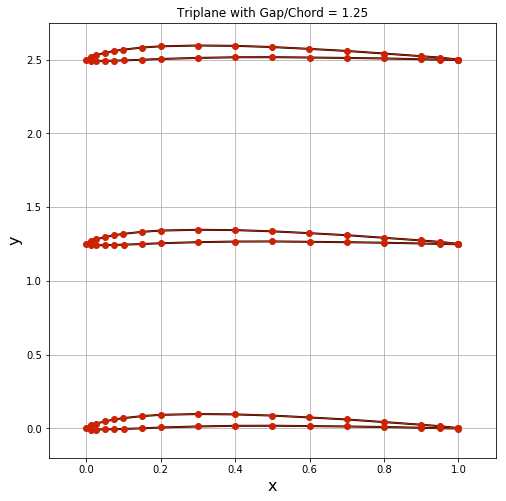

In [22]:
# create the triplane
y_gap = 1.25
x_t_1, y_t_1, x_t_2, y_t_2, bot_panels, mid_panels, top_panels, panelS_tri = \
create_triplane (x_m, y_m, x_n1,y_gap)
#bot_panels = lower_panels_bi

plot_triplane_panels(x_m, y_m, x_t_1, y_t_1, x_t_2, y_t_2, bot_panels, mid_panels, top_panels)

Great! Now let's create a function (in helper.py) to solve for the lift of the system for each angle of attack. While we're at it let's compute the rest of the monoplane and biplane lifts at gap/chord = 1.25.

In [28]:
# create the remaining freestream flows:
freestream_0 = Freestream(u_inf=1.0, alpha=0.0)
freestream_2 = Freestream(u_inf=1.0, alpha=2.0)
freestream_12 = Freestream(u_inf=1.0, alpha=12.0)

# solve for the triplane lift at AOA: 0-12
# here each is multiplied by (2/3) for an area correction
N=int(len(panelS_tri)/3)
L_tri_0 = solve_triplane(panelS_tri, freestream_0, N)*(2/3)
L_tri_2 = solve_triplane(panelS_tri, freestream_2, N)*(2/3)
L_tri_4 = solve_triplane(panelS_tri, freestream_4, N)*(2/3)
L_tri_6 = solve_triplane(panelS_tri, freestream_6, N)*(2/3)
L_tri_8 = solve_triplane(panelS_tri, freestream_8, N)*(2/3)
L_tri_10 = solve_triplane(panelS_tri, freestream_10, N)*(2/3)
L_tri_12 = solve_triplane(panelS_tri, freestream_12, N)*(2/3)

# remaining monoplane lift: AOA = 0, 2, 12
# multiply each term by 2 for an area correction
L_m0 = 2*solve_monoplane(lower_panels_bi, freestream_0,N)
print(L_m0)
L_m2 = 2*solve_monoplane(lower_panels_bi, freestream_2,N)
print(L_m2)
L_m12 = 2*solve_monoplane(lower_panels_bi, freestream_12,N)
print(L_m12)

# remaining biplane lift: AOA = 0, 2, 12
L_bi0_3 = solve_biplane(panelS_bi_3, freestream_0, N)
print(L_bi0_3)
L_bi2_3 = solve_biplane(panelS_bi_3, freestream_2, N)
print(L_bi2_3)
L_bi12_3 = solve_biplane(panelS_bi_3, freestream_12, N)
print(L_bi12_3)

0.3467065317656596
0.6272886206380337
1.9837068782070137
0.5693539132721956
0.8153808790643176
1.995424263958883


In [27]:
data = numpy.round(numpy.array([[L_m0/L_m0, L_bi0_3/L_m0, L_tri_0/L_m0],
                   [L_m2/L_m2, L_bi2_3/L_m2, L_tri_2/L_m2],
                   [L_m4/L_m4, L_bi4_3/L_m4, L_tri_4/L_m4],
                   [L_m6/L_m6, L_bi6_3/L_m6, L_tri_6/L_m6],
                    [L_m8/L_m8, L_bi8_3/L_m8, L_tri_8/L_m8],
                    [L_m10/L_m10, L_bi10_3/L_m10, L_tri_10/L_m10],
                    [L_m12/L_m12, L_bi12_3/L_m12, L_tri_12/L_m12]])*100, decimals = 1)
row_header = ['0','2','4','6', '8', '10', '12']
column_header = (['Monoplane', 'Biplane', 'Triplane'])
df = pandas.DataFrame(data, row_header, column_header)
df.index.name = 'AOA'
df

,Monoplane,Biplane,Triplane
AOA,,,
0,100.0,164.2,86.3
2,100.0,130.0,83.5
4,100.0,87.9,82.0
6,100.0,87.8,80.9
8,100.0,87.8,79.9
10,100.0,87.8,78.9
12,100.0,100.6,78.0


### Step 3: 


### Challenge
If we look at pictures of biplanes and triplanes used in WWI we can see that most do not have the wings placed vertically above and below one another as we have done in this tutorial. Instead, the lower wings are often slightly behind (in the x direction) the upper wings in a "staggered" configuration. How would our results change if we changed the wing geometries by adding staggering?

<img src="stagger.JPG" height="200" width="500">

On p.38-39 Grant states, "When the wings are staggered 0.4 of the chord, both lift and efficiency increase 5%. A negative stagger of 0.4 the chord reduces lift and in most cases efficiency in the same ratio. A positive stagger of ½ of the chord is best for model planes."

Tasks: 

1. Create a biplane with a positive stagger of 0.4 chord and a biplane with a negative stagger of 0.4 chord.
2. Create a triplane with a positive stagger of 0.4 chord and a triplane with a negative stagger of 0.4 chord.
3. Compare results to Grant's claim of a 5% increase in lift for 0.4x chord positive stagger and 5% decrease in lift for 0.4x negative stagger, with reference to a biplane and triplane with a gap/chord ratio of 1.25.
4. Try varying the amount of positive and negative stagger for both planes past 0.4x chord and see how this affects the change in lift.
5. Why do you think the lift is affected when the wings are staggered?

### References:

1. Grant, Charles "<i>Model Airplane Design and Theory of Flight</i>," Air Age Inc., 1944, p.32-39 {https://babel.hathitrust.org/cgi/pt?id=mdp.39015006062536;view=1up;seq=52}
2. Wikipedia, "Biplane: Advantages and Disadvantages," {https://en.wikipedia.org/wiki/Biplane}
3. Wikipedia, "Monoplane: History," {https://en.wikipedia.org/wiki/Monoplane}
4. Wikipedia, "Triplane: Design principles, History," {https://en.wikipedia.org/wiki/Triplane}
5. Aviation Stack Exchange, "Why are there no longer any biplanes?" {https://aviation.stackexchange.com/questions/12143/why-are-there-no-longer-any-biplanes}
6. Aviation Stack Exchange, "What special handling characteristics or techniques do biplanes have?" {https://aviation.stackexchange.com/questions/9981/what-special-handling-characteristics-or-techniques-do-biplanes-have?lq=1}
7. Aviation Stack Exchange, "What are the advantages and disadvantages of a monoplane, biplane and triplane? [duplicate]" {https://aviation.stackexchange.com/questions/25778/what-are-the-advantages-and-disadvantages-of-a-monoplane-biplane-and-triplane?rq=1}
8. Wikipedia, "Manfred von Richthofen: Piloting career," {https://en.wikipedia.org/wiki/Manfred_von_Richthofen}

#### Image Credits:
1. Lloyd Leichentritt, "Fokker Dr.I 127/17" {http://www.fokkerdr1.com/127_17.htm}
2. Bryan R. Swopes, "This Day in Aviation: 17 September 1916," Sept. 2018 {https://www.thisdayinaviation.com/tag/albatros-d-ii/}